In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [12]:
from core.data_loader import DataLoader
import os
import sys
from core.backtester import Backtester
from strategies.atr_breakout import ATRTrailingBreakout
from strategies.multi_momentum import MultiTimeframeMomentum
from strategies.vwap_reversion import VWAPReversion
from strategies.bb_rsi import BB_RSI
import logging
from datetime import datetime
import pandas as pd

# Налаштування логування
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Завантаження даних
loader = DataLoader()
data_file = 'sol_1m_mrhapr25_askbid.parquet'
if not os.path.exists(os.path.join('data', data_file)):
    logger.info("Завантаження даних...")
    df = loader.fetch_historical_bid_ask('SOLBTC', '1m', start_date='2025-03-01', end_date='2025-05-01')
    loader.save_data({'SOLBTC': df}, data_file)
else:
    df = loader.load_data(data_file, '1h')
    df = df['SOLBTC']
data = df['close']
symbol = 'SOLBTC'
df
# split_point = len(df) // 2
# test_df = df.iloc[split_point:]
# df = df.iloc[:split_point]
# test_df

,open,high,low,close,volume,bid,ask
timestamp,,,,,,,
2025-03-01 00:00:00,0.001757,0.001757,0.001736,0.001740,10100.174,0.001740,0.001740
2025-03-01 01:00:00,0.001741,0.001785,0.001735,0.001775,21953.014,0.001775,0.001775
2025-03-01 02:00:00,0.001775,0.001775,0.001718,0.001727,22484.943,0.001727,0.001727
2025-03-01 03:00:00,0.001728,0.001731,0.001708,0.001708,13193.772,0.001708,0.001708
2025-03-01 04:00:00,0.001708,0.001711,0.001690,0.001703,9061.857,0.001702,0.001704
...,...,...,...,...,...,...,...
2025-04-15 10:00:00,0.001553,0.001557,0.001540,0.001545,6901.476,0.001545,0.001546
2025-04-15 11:00:00,0.001546,0.001549,0.001540,0.001544,4864.651,0.001544,0.001544
2025-04-15 12:00:00,0.001544,0.001552,0.001536,0.001545,4593.103,0.001545,0.001545


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf  # Optional - for fetching data

def calculate_bollinger_bands(data, window=20, num_std=2):
    """
    Calculate Bollinger Bands with forward shift to avoid look-ahead bias.
    
    Parameters:
    - data: Pandas Series of closing prices
    - window: Moving average window (typically 20)
    - num_std: Number of standard deviations for the bands (typically 2)
    
    Returns:
    - DataFrame with columns: Middle Band, Upper Band, Lower Band
    """
    rolling_mean = data.rolling(window=window).mean()
    rolling_std = data.rolling(window=window).std()
    
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    
    # Shift all bands forward by 1 to avoid look-ahead bias
    return pd.DataFrame({
        'Middle Band': rolling_mean.shift(1),
        'Upper Band': upper_band.shift(1),
        'Lower Band': lower_band.shift(1)
    })

# def keep_last_true_in_sequence(series):
#     """
#     Process a boolean Series to keep only the last True in each uninterrupted sequence.
    
#     Args:
#         series: pandas Series of boolean values
        
#     Returns:
#         A new Series with only the last True from each True sequence
#     """
#     # Initialize the result Series with all False
#     result = pd.Series(False, index=series.index)
    
#     # Find the boundaries of True sequences
#     shifted = series.shift(1, fill_value=False)
#     starts = series & ~shifted  # First True in sequence
#     ends = series & ~series.shift(-1, fill_value=False)  # Last True in sequence
    
#     # Keep only the last True in each sequence
#     result[ends] = True
    
#     return result

def identify_crossovers(close_prices, bb_df):
    """
    Identify where price crosses Bollinger Bands.
    
    Returns:
    - DataFrame with crossover signals:
      - 'Upper Cross': Price crosses above upper band
      - 'Lower Cross': Price crosses below lower band
    """
    signals = pd.DataFrame(index=close_prices.index)
    signals['Upper Cross'] = (close_prices > bb_df['Upper Band'])
    signals['Lower Cross'] = (close_prices < bb_df['Lower Band'])
    return signals 

def generate_trading_signals(close_prices, bb_df, signals):
    """
    Generate a DataFrame with clear trading signals and positions.
    """
    trades = pd.DataFrame(index=close_prices.index)
    trades['Price'] = close_prices
    trades = trades.join(bb_df).join(signals)
    
    # Initialize position column
    trades['Position'] = 0
    
    # Generate signals (1 for long, -1 for short)
    trades.loc[trades['Lower Cross'], 'Position'] = 1
    trades.loc[trades['Upper Cross'], 'Position'] = -1
    
    return trades

def plot_bollinger_bands_with_signals(data, bb_df, signals, symbol=''):
    """
    Enhanced plot showing:
    - Price and Bollinger Bands
    - Crossover points
    - Fill between bands
    """
    plt.figure(figsize=(14, 7))
    
    # Plot price and bands
    plt.plot(data.index, data, label='Close Price', color='blue', alpha=0.7, linewidth=1.5)
    plt.plot(bb_df.index, bb_df['Middle Band'], label='Middle Band (SMA)', color='red', linestyle='--')
    plt.plot(bb_df.index, bb_df['Upper Band'], label='Upper Band', color='green', linestyle='-')
    plt.plot(bb_df.index, bb_df['Lower Band'], label='Lower Band', color='green', linestyle='-')
    
    # Fill between bands
    plt.fill_between(bb_df.index, bb_df['Upper Band'], bb_df['Lower Band'], color='gray', alpha=0.1)
    
    # Plot crossover signals
    upper_crosses = signals[signals['Upper Cross']].index
    lower_crosses = signals[signals['Lower Cross']].index
    
    plt.scatter(upper_crosses, data[upper_crosses], 
               color='red', marker='v', s=100, label='Upper Band Cross (Sell Signal)')
    plt.scatter(lower_crosses, data[lower_crosses], 
               color='green', marker='^', s=100, label='Lower Band Cross (Buy Signal)')
    
    plt.title(f'Bollinger Bands with Trading Signals - {symbol}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
import numpy as np
import pandas as pd
import vectorbt as vbt

def bb_strategy_tester(df, window=20, std_dev=2.0):
    """
    Enhanced Bollinger Bands strategy that:
    1. Triggers when price ENTERS bands (not breaks through)
    2. Uses special price calculation formula
    3. Provides detailed trade statistics
    
    Args:
        df: DataFrame with columns ['open', 'high', 'low', 'close', 'volume']
        window: BB window size
        std_dev: BB standard deviation multiplier
    
    Returns:
        Tuple of (portfolio, cross_stats)
    """
    # Calculate Bollinger Bands
    bb = vbt.BBANDS.run(df['close'], window=window, alpha=std_dev)
    
    # Initialize signals and price trackers
    entries = pd.Series(False, index=df.index)
    exits = pd.Series(False, index=df.index)
    prices = pd.Series(np.nan, index=df.index)

    last_buy_price = -np.inf
    last_sell_price = np.inf
    pers = 0.04
    
    for i in range(1, len(df)):
        prev_high = df['high'].iloc[i-1]
        prev_low = df['low'].iloc[i-1]
        current_low = df['low'].iloc[i]
        current_high = df['high'].iloc[i]
        current_close = df['close'].iloc[i]
        lower_band = bb.lower.shift(1).iloc[i]
        upper_band = bb.upper.shift(1).iloc[i]
        
        # Buy signal: Price enters lower band (from above)
        if (
            # (last_sell_price > lower_band * (1 + pers)) and
            (prev_low < lower_band) and (current_high > lower_band)):
            entries.iloc[i] = True
            prices.iloc[i] = lower_band  # Use band price
            last_buy_price = lower_band

        # Sell signal: Price enters upper band (from below)
        if (
            # (last_buy_price < upper_band * 1 - pers) and
            (prev_high < upper_band) and (current_low < upper_band)):
            exits.iloc[i] = True
            prices.iloc[i] = upper_band  # Use band price
            last_sell_price = upper_band

    # Create portfolio using actual execution prices
    pf = vbt.Portfolio.from_signals(
        close=df['close'],
        entries=entries,
        exits=exits,
        price=prices.fillna(df['close']),
        fees=0.001,  # 0.1% fee per trade
        # slippage=0.001,  # 0.1% slippage per trade
        freq='1s'
    )
    
    return pf

# Example usage:
# Load your data
# df = pd.read_csv('your_data.csv', parse_dates=['date'], index_col='date')
# results = bb_strategy_tester(df, window=14, std_dev=1.0)
# results.stats()['Total Return [%]']
# results.plot().show()


np.float64(31.617281022764658)

In [9]:
def bb_strategy_tester(df, window=14*60, std_dev=2.0, step_size=60):
    """
    Bollinger Bands strategy that:
    1. Calculates BB on a large window (e.g., 14 hours for 1-min data)
    2. Checks for crossovers at a more granular level (e.g., every minute)
    3. Steps through the data in larger increments (e.g., 60 periods for 1-hour steps)
    
    Args:
        df: DataFrame with columns ['open', 'high', 'low', 'close', 'volume']
        window: BB window size in periods (e.g., 14*60 for 14 hours in 1-min data)
        std_dev: BB standard deviation multiplier
        step_size: Number of periods to step through after each window (e.g., 60 for 1-hour steps)
    
    Returns:
        Portfolio object
    """
    # Calculate Bollinger Bands on the full dataset
    bb = vbt.BBANDS.run(df['close'], window=window, alpha=std_dev)
    
    # Initialize signals and price trackers
    entries = pd.Series(False, index=df.index)
    exits = pd.Series(False, index=df.index)
    prices = pd.Series(np.nan, index=df.index)

    last_buy_price = -np.inf
    last_sell_price = np.inf
    pers = 0.04
    
    # Outer loop: Step through the data in large increments
    for i in range(window, len(df), step_size):
        # Inner loop: Check each period within the current step
        for j in range(i, min(i+step_size, len(df))):
            prev_high = df['high'].iloc[j-1]
            prev_low = df['low'].iloc[j-1]
            current_low = df['low'].iloc[j]
            current_high = df['high'].iloc[j]
            current_close = df['close'].iloc[j]
            lower_band = bb.lower.iloc[j]  # Current band (no shift)
            upper_band = bb.upper.iloc[j]  # Current band (no shift)
            
            # Buy signal: Price enters lower band (from above)
            if ((prev_low > lower_band) and (current_low <= lower_band)):
                entries.iloc[j] = True
                prices.iloc[j] = lower_band  # Use band price
                last_buy_price = lower_band

            # Sell signal: Price enters upper band (from below)
            if ((prev_high < upper_band) and (current_high >= upper_band)):
                exits.iloc[j] = True
                prices.iloc[j] = upper_band  # Use band price
                last_sell_price = upper_band

    # Create portfolio using actual execution prices
    pf = vbt.Portfolio.from_signals(
        close=df['close'],
        entries=entries,
        exits=exits,
        price=prices.fillna(df['close']),
        fees=0.001,  # 0.1% fee per trade
        freq='1m'
    )

    return pf

results = bb_strategy_tester(df, window=14*60, std_dev=1.0, step_size=60)
results.stats()['Total Return [%]']

np.float64(-9.549877349478038)

In [13]:
results.plot()

FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'f905009b-2ac4-460d-92d2-6040999560ce',
              'x': array([datetime.datetime(2025, 3, 1, 0, 0),
                          datetime.datetime(2025, 3, 1, 0, 1),
                          datetime.datetime(2025, 3, 1, 0, 2), ...,
                          datetime.datetime(2025, 3, 23, 19, 27),
                          datetime.datetime(2025, 3, 23, 19, 28),
                          datetime.datetime(2025, 3, 23, 19, 29)], dtype=object),
              'xaxis': 'x',
              'y': array([0.0017536, 0.0017531, 0.0017511, ..., 0.0015372, 0.0015367, 0.0015368]),
              'yaxis': 'y'},
             {'customdata': array([[0.00000000e+00, 5.71903257e+04, 9.99000999e-02],
                                   [2.00000000e+00, 5.66797851e+04, 9.98368281e-02],
              

In [14]:
import numpy as np
import pandas as pd
import vectorbt as vbt
import yfinance as yf
from matplotlib import pyplot as plt

def optimize_bollinger_bands(df, window_range, std_range, wait_range):
    """
    Optimize Bollinger Bands with execution price memory using iloc:
    - For buys: must be ≤ last sell price * 0.96 (4% lower)
    - For sells: must be ≥ last buy price * 1.04 (4% higher)
    """
    results = []
    total_combinations = len(window_range) * len(std_range) * len(wait_range)
    progress_bar = tqdm(total=total_combinations, desc="Optimizing parameters")
    
    for params in [(w, s, m) for w in window_range for s in std_range for m in wait_range]:
        window, std, m = params
        
        pf = bb_strategy_tester(df, window, std)
        
        # Store results
        stats = pf.stats()
        results.append({
            'window': window,
            'std': std,
            'total_return': stats['Total Return [%]'],
            'sharpe_ratio': stats['Sharpe Ratio'],
            'win_rate': stats['Win Rate [%]'],
            'profit_factor': stats['Profit Factor'],
            'trades': stats['Total Trades'],
            'portfolio': pf
        })
        
        progress_bar.update(1)
    
    progress_bar.close()
    results_df = pd.DataFrame(results)
    
    best_idx = results_df['total_return'].idxmax()
    best_window = results_df.loc[best_idx, 'window']
    best_std = results_df.loc[best_idx, 'std']
    best_pf = results_df.loc[best_idx, 'portfolio']
    
    return best_window, best_std, results_df, best_pf


In [ ]:

# Parameter ranges to test
window_range = range(1, 36, 1)  # From 10 to 50 in steps of 5
std_range = np.arange(0.5, 3.0, 0.1)  # From 1.5 to 3.0 in steps of 0.25
wait_range = np.arange(0, 1, 1)  # From 0.5 to 1.5 in steps of 0.1

# Run optimization
best_window, best_std, results_df, best_pf = optimize_bollinger_bands(
    df, window_range, std_range, [0]
)

print(f"\nOptimal Parameters - Window: {best_window}, Std: {best_std:.2f}")
print("\nPerformance Metrics with Optimal Parameters:")
print(best_pf.stats())

# Plot heatmap of Total Return
pivot_table = results_df.pivot(index='window', columns='std', values='total_return')
plt.figure(figsize=(12, 6))
plt.title('Total Return Heatmap')
plt.xlabel('Standard Deviation')
plt.ylabel('Window Size')
plt.imshow(pivot_table, cmap='viridis', aspect='auto')
plt.colorbar(label='Total Return')
plt.xticks(range(len(std_range)), [f"{s:.2f}" for s in std_range])
plt.yticks(range(len(window_range)), window_range)
plt.show()

Optimizing parameters:   0%|          | 0/875 [00:00<?, ?it/s]

Optimizing parameters:   1%|▏         | 11/875 [04:55<6:29:34, 27.05s/it]

In [ ]:
# bb = vbt.BBANDS.run(close_price, window=window, alpha=std)
        
#         # Initialize execution price memory
#         last_buy_price = np.nan
#         last_sell_price = np.nan
        
#         # Initialize filtered signals
#         filtered_entries = pd.Series(False, index=close_price.index)
#         filtered_exits = pd.Series(False, index=close_price.index)
        
#         # Generate raw signals
#         # df = identify_crossovers(close_price, 
#         #     pd.DataFrame({'Upper Band': bb.upper.shift(1), 'Lower Band': bb.lower.shift(1)}))
#         # raw_entries = df['Upper Cross']
#         # raw_exits = df['Lower Cross']

#         raw_entries = close_price.vbt.crossed_above(bb.lower.shift(1), wait=m)
#         raw_exits = close_price.vbt.crossed_below(bb.upper.shift(1), wait=m)            
        
#         # for i in range(len(close_price)):
#         #     current_price = close_price.iloc[i]
            
#         #     # Handle buys
#         #     if raw_entries.iloc[i]:
#         #         if np.isnan(last_sell_price) or current_price <= last_sell_price * 0.96:
#         #             filtered_entries.iloc[i] = True
#         #             last_buy_price = current_price
            
#         #     # Handle sells
#         #     if raw_exits.iloc[i]:
#         #         if np.isnan(last_buy_price) or current_price >= last_buy_price * 1.04:
#         #             filtered_exits.iloc[i] = True
#         #             last_sell_price = current_price
        
#         # Run backtest
#         pf = vbt.Portfolio.from_signals(
#             close_price,
#             raw_entries, raw_exits,
#             # filtered_entries, filtered_exits,
#             fees=0.001,
#             slippage=0.001,
#             freq='1h',
#             price = bb.lower.where(raw_entries)  # Long entries
#                 .fillna(bb.upper.where(raw_exits))  # Long exits
#                 .fillna(close_price)
#         )

In [32]:
best_pf.plot()

FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': '33d72a9b-2938-4b49-b514-6308db8bf4d9',
              'x': array([datetime.datetime(2025, 3, 1, 0, 0),
                          datetime.datetime(2025, 3, 1, 1, 0),
                          datetime.datetime(2025, 3, 1, 2, 0), ...,
                          datetime.datetime(2025, 4, 15, 8, 0),
                          datetime.datetime(2025, 4, 15, 9, 0),
                          datetime.datetime(2025, 4, 15, 10, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([0.0017401, 0.0017747, 0.0017272, ..., 0.0015342, 0.0015527, 0.001556 ]),
              'yaxis': 'y'},
             {'customdata': array([[0.00000000e+00, 5.91159875e+04, 9.99000999e-02],
                                   [2.00000000e+00, 6.03963525e+04, 1.00121751e-01],
                   

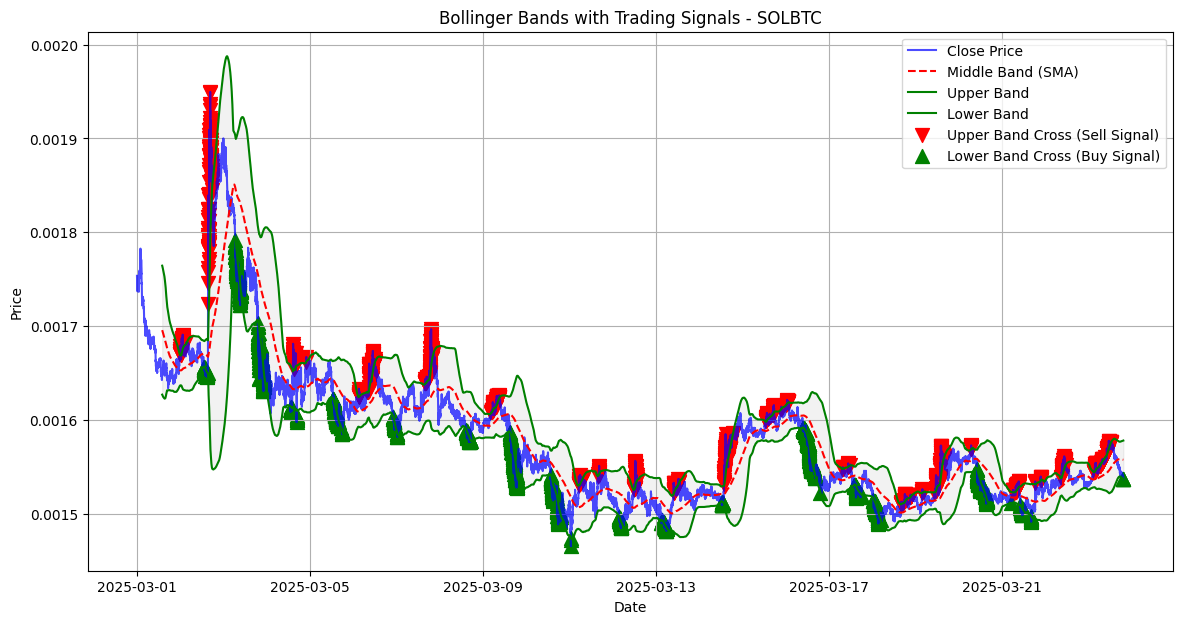

In [11]:
# bb_df = calculate_bollinger_bands(data, best_window, best_std)
bb_df = calculate_bollinger_bands(df['close'], 14*60, 2)
signals = identify_crossovers(df['close'], bb_df)
trades = generate_trading_signals(df['close'], bb_df, signals)

# Print some trading signals
# print("Sample Trading Signals:")
# print(trades[trades['Position'] != 0].head(10))

# Plot with signals
plot_bollinger_bands_with_signals(df['close'], bb_df, signals, symbol)

In [27]:
entries = data.vbt.crossed_above(bb_df['Lower Band'])
exits = data.vbt.crossed_below(bb_df['Upper Band'])

pf = vbt.Portfolio.from_signals(
    data,
    entries, exits,
    # signals['Lower Cross'], signals['Upper Cross'],
    fees=0.001,  # 0.1% fee per trade
    slippage=0.001,  # 0.1% slippage per trade
    freq='1h',
)
pf.plot()

FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': '41027f9b-44bd-468f-9aea-cfafeab5f1f4',
              'x': array([datetime.datetime(2025, 3, 1, 0, 0),
                          datetime.datetime(2025, 3, 1, 1, 0),
                          datetime.datetime(2025, 3, 1, 2, 0), ...,
                          datetime.datetime(2025, 4, 15, 8, 0),
                          datetime.datetime(2025, 4, 15, 9, 0),
                          datetime.datetime(2025, 4, 15, 10, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([0.0017401, 0.0017747, 0.0017272, ..., 0.0015342, 0.0015527, 0.001556 ]),
              'yaxis': 'y'},
             {'customdata': array([[0.00000000e+00, 6.03533500e+04, 9.99000999e-02],
                                   [2.00000000e+00, 6.27768723e+04, 1.09447817e-01],
                   

In [28]:
pf.stats()

Start                         2025-03-01 00:00:00
End                           2025-04-15 10:00:00
Period                           45 days 11:00:00
Start Value                                 100.0
End Value                              110.172294
Total Return [%]                        10.172294
Benchmark Return [%]                   -10.579852
Max Gross Exposure [%]                      100.0
Total Fees Paid                          3.631199
Max Drawdown [%]                        19.169179
Max Drawdown Duration            43 days 18:00:00
Total Trades                                   18
Total Closed Trades                            17
Total Open Trades                               1
Open Trade PnL                           1.347463
Win Rate [%]                            52.941176
Best Trade [%]                           9.566822
Worst Trade [%]                         -6.742142
Avg Winning Trade [%]                    3.293734
Avg Losing Trade [%]                    -2.497899


In [32]:
bb = vbt.BBANDS.run(data, window=best_window, alpha=best_std)
entries = data.vbt.crossed_above(bb.lower.shift(1))
exits = data.vbt.crossed_below(bb.upper.shift(1))

pf = vbt.Portfolio.from_signals(
    data,
    entries, exits,
    fees=0.001,
    slippage=0.001,
    freq='1h',
)
pf.stats()


Start                         2025-03-01 00:00:00
End                           2025-04-15 10:00:00
Period                           45 days 11:00:00
Start Value                                 100.0
End Value                              117.267752
Total Return [%]                        17.267752
Benchmark Return [%]                   -10.579852
Max Gross Exposure [%]                      100.0
Total Fees Paid                           4.40554
Max Drawdown [%]                        15.348538
Max Drawdown Duration            39 days 20:00:00
Total Trades                                   21
Total Closed Trades                            20
Total Open Trades                               1
Open Trade PnL                           1.434244
Win Rate [%]                                 60.0
Best Trade [%]                           9.566822
Worst Trade [%]                         -6.742142
Avg Winning Trade [%]                    2.951355
Avg Losing Trade [%]                    -2.433203
